## Requirements

A [pip requirements file](https://pip.pypa.io/en/stable/user_guide/#requirements-files) can be found at: [/sashimdig/requirements.txt](../requirements.txt)

Notable requirements

|package    |version |
|----       |-----   |
|tensorflow | 0.10.0 |
| tflearn   | 0.2.1  |


----
### [TFLearn installation instructions](http://tflearn.org/installation/)
Must install older tensorflow version 0.10 (NOT the latest 1.0) to work w/ `tflearn`

```
# Mac OS X, CPU only, Python 3.4 or 3.5:
$ export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-0.10.0-py3-none-any.whl

# Mac OS X, GPU enabled, Python 3.4 or 3.5:
$ export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/mac/gpu/tensorflow-0.10.0-py3-none-any.whl

sudo -H pip3 install --upgrade $TF_BINARY_URL --ignore-installed
```

In [1]:
%matplotlib inline
import numpy             as np
import pandas            as pd
import matplotlib
import seaborn           as sns
import matplotlib.pyplot as plt
import os
from   os      import getcwd
from   os      import listdir
from   os.path import isfile, join, isdir

import skimage
from   skimage import measure
from   skimage import io

from   PIL     import Image

from   sklearn.model_selection    import train_test_split
from   sklearn.metrics            import log_loss
from   sklearn.preprocessing      import LabelEncoder
from   skimage.transform          import resize

import tensorflow as tf
import tflearn
from   tflearn.data_utils         import shuffle
from   tflearn.layers.core        import input_data, dropout, fully_connected
from   tflearn.layers.conv        import conv_2d, max_pool_2d
from   tflearn.layers.estimator   import regression
from   tflearn.data_preprocessing import ImagePreprocessing
from   tflearn.data_augmentation  import ImageAugmentation

In [2]:
def get_paths(foldNames):
  
    paths = dict.fromkeys(foldNames)

    for idx,g in enumerate(foldNames):
        fileNames = [f for f in listdir(join(trainPath,g)) if isfile(join(trainPath,g, f))]
        for i,f in enumerate(fileNames):
            fileNames[i] = join(trainPath,g,f)     
        paths[g] = fileNames
        
    return paths

def read_image(src):
    """Read and resize individual images"""
    im = io.imread(src)
    im = resize(im, (ROWS, COLS))
    return im


# Setup

In [3]:
trainPath      = '../data/raw/train'
testPath       = '../data/raw/test_stg1'
submitPath     = '../data/raw'
fish_classes   = [f for f in listdir(trainPath) if isdir(join(trainPath, f))]
groupData      = pd.DataFrame ({'group': fish_classes})
fish_paths     = get_paths(fish_classes)

# Model Parameters

In [4]:
subsample_amnt  = 'all'  # len(files) = 3777
downsample_amnt = 8
ROWS            = int(720  / downsample_amnt)
COLS            = int(1280 / downsample_amnt)
CHANNELS        = 3
NUM_CATEGORIES  = len(fish_classes)


# Build x and y arrays

In [5]:
%%time

for idx,fish in enumerate(fish_classes):
    groupData.ix[idx,'num files'] = int(len(fish_paths[fish]))
    
files = []
Y_cat = []

for fish in fish_classes:
    fish_files = fish_paths[fish]
    files.extend(fish_files)
    
    y_fish = np.tile(fish, len(fish_files))
    Y_cat.extend(y_fish)
  
Y_cat = np.array(Y_cat) 
print(Y_cat)

['ALB' 'ALB' 'ALB' ..., 'YFT' 'YFT' 'YFT']
CPU times: user 8.81 ms, sys: 1.7 ms, total: 10.5 ms
Wall time: 9.5 ms


## Sub-sample the training set

In [6]:
if isinstance(subsample_amnt, int):
    from sklearn.utils import resample
    files, Y_cat = resample(files, Y_cat, 
                        n_samples = subsample_amnt, 
                        replace   = False)

## Load all training images into `X_all`

In [7]:
%%time

X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS))

for i, f in enumerate(files): 
    im        = read_image(f)
    X_all[i]  = im
    if i%500 == 0: print('Processed {} of {}'.format(i, len(files)))


Processed 0 of 3777
Processed 100 of 3777
Processed 200 of 3777
Processed 300 of 3777
Processed 400 of 3777
Processed 500 of 3777
Processed 600 of 3777
Processed 700 of 3777
Processed 800 of 3777
Processed 900 of 3777
Processed 1000 of 3777
Processed 1100 of 3777
Processed 1200 of 3777
Processed 1300 of 3777
Processed 1400 of 3777
Processed 1500 of 3777
Processed 1600 of 3777
Processed 1700 of 3777
Processed 1800 of 3777
Processed 1900 of 3777
Processed 2000 of 3777
Processed 2100 of 3777
Processed 2200 of 3777
Processed 2300 of 3777
Processed 2400 of 3777
Processed 2500 of 3777
Processed 2600 of 3777
Processed 2700 of 3777
Processed 2800 of 3777
Processed 2900 of 3777
Processed 3000 of 3777
Processed 3100 of 3777
Processed 3200 of 3777
Processed 3300 of 3777
Processed 3400 of 3777
Processed 3500 of 3777
Processed 3600 of 3777
Processed 3700 of 3777
CPU times: user 3min 57s, sys: 58.2 s, total: 4min 56s
Wall time: 5min 5s


### View resampled image

In [8]:
def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure(figsize=(10,10))
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        plt.imshow(image, cmap='gray', interpolation='nearest')
        plt.axis('off')
        a.set_title(title)
        #         print(submission.iloc[jImage,:])
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

### Test: Ensure that loaded images are correctly stored in `X_all`

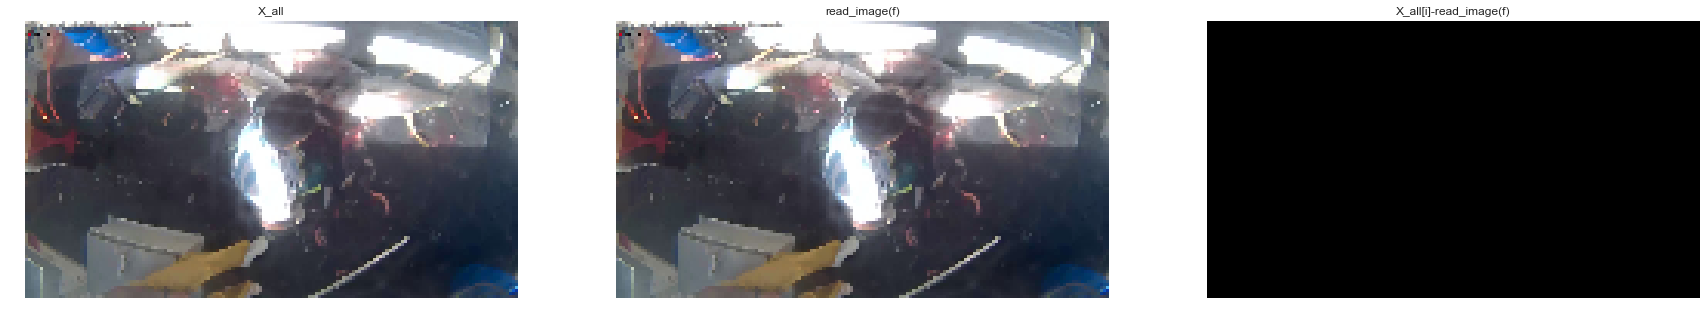

In [9]:
show_images(images=[X_all[i], 
                    read_image(f), 
                    X_all[i]-im], 
            titles=['X_all',
                    'read_image(f)', 
                    'X_all[i]-read_image(f)'])

# Training data
* One hot encoding labels
* Split data


In [10]:
%%time

# One Hot Encoding Labels
#    Transform the categorical array Y_all into matrix of the same height, 
#    but with a boolean column for each category.
Y_all = LabelEncoder().fit_transform(Y_cat)
Y_all = tflearn.data_utils.to_categorical(Y_all, NUM_CATEGORIES)

# test_size: between 0 and 1. proportion of the dataset to include in the test split
# random_state: Pseudo-random number generator state used for random sampling. How to shoose this?
# stratify: this is ensuring that the split datasets are balanced, i.e. contains the same 
# percentage of classes

X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, 
                                                      test_size    =0.2, 
                                                      random_state =23, 
                                                      stratify     =Y_all)

CPU times: user 289 ms, sys: 407 ms, total: 697 ms
Wall time: 711 ms


## Test Data

In [11]:
%%time

# read in test photo set
test_files = [im for im in os.listdir(testPath)]
test       = np.ndarray((len(test_files), ROWS, COLS, CHANNELS))


for i, im in enumerate(test_files): 
    test[i] = read_image(join(testPath,im))

CPU times: user 1min 3s, sys: 15.9 s, total: 1min 19s
Wall time: 1min 20s


# TFLEARN

## Define the model


In [12]:
def dnn_test1():
    #needed to run this tensorflow operation in order to build the network and subsequently 
    #create the model, multiple times. Rebuilding without resetting the tf.Graph object produces
    #errors. Could also get around this issue by restarting kernel, but that's annoying.
    with tf.Graph().as_default():
    
    
#         # Real-time data preprocessing
#         img_prep = ImagePreprocessing()
#         img_prep.add_featurewise_zero_center()
        
        
#         # Convolutional network building
#         network = input_data(shape=[None, ROWS, COLS, CHANNELS], 
#                             data_preprocessing=img_prep)

        # input layer
        network = input_data(shape=[None, ROWS, COLS, CHANNELS])
        
        # hidden layers
        network = conv_2d(network, 32, 3, activation='relu', regularizer='L2')
        network = max_pool_2d(network, 2)
        network = conv_2d(network, 64, 3, activation='relu', regularizer='L2')
        network = conv_2d(network, 64, 3, activation='relu', regularizer='L2')
        network = max_pool_2d(network, 2)
        network = fully_connected(network, 512, activation='relu', regularizer='L2')
        network = dropout(network, 0.5)
        
        
        # output layer
        network = fully_connected(network, NUM_CATEGORIES, activation='softmax', regularizer='L2')
        network = regression(network, 
                             loss='categorical_crossentropy',
                             learning_rate=0.01)
        return tflearn.DNN(network, 
                           tensorboard_verbose=0)

# Define model
model = dnn_test1()

In [13]:
%%time

# Start training (apply gradient descent algorithm). Will want to specify multiple epochs 
# typically unless just testing


# Train using classifier
model.fit(X_train, Y_train, 
          n_epoch        = 20, 
          shuffle        = True, 
          validation_set = (X_valid, Y_valid),
          show_metric    = True, 
          batch_size     = 96)

Training Step: 640  | total loss: 0.31744
| Adam | epoch: 020 | loss: 0.31744 - acc: 0.8996 | val_loss: 0.24167 - val_acc: 0.9286 -- iter: 3021/3021
Training Step: 640  | total loss: 0.31744
| Adam | epoch: 020 | loss: 0.31744 - acc: 0.8996 | val_loss: 0.24167 - val_acc: 0.9286 -- iter: 3021/3021
--
CPU times: user 3h 17min 48s, sys: 35min 14s, total: 3h 53min 3s
Wall time: 39min 49s


## Predict & save to submission file

In [14]:
%%time

#model predict
test_preds1 = model.predict(test)

CPU times: user 59 s, sys: 21.4 s, total: 1min 20s
Wall time: 17.3 s


In [15]:
%%time

submission = pd.DataFrame(test_preds1, columns=fish_classes)
submission.insert(0, 'image', test_files)
submission.to_csv(join(submitPath,'jfa-2.0-submission.csv'), 
                 index=False) 
submission.head()

CPU times: user 27.6 ms, sys: 31.2 ms, total: 58.8 ms
Wall time: 179 ms


In [16]:
def sample_prediction(jImage):
    im = read_image(join(testPath, submission.image[jImage]))
    plt.figure(figsize=(5, 5))
    plt.imshow(im, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    foo = submission.iloc[jImage,1:]
    print(foo.sort_values(ascending=False))


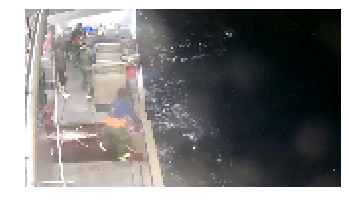

YFT        0.348901
ALB        0.321706
BET        0.235876
NoF       0.0518343
OTHER     0.0124994
SHARK     0.0115314
LAG      0.00958655
DOL      0.00806566
Name: 29, dtype: object


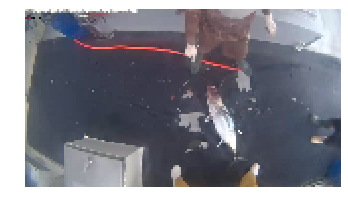

ALB         0.999637
NoF      0.000209115
BET      9.60389e-05
YFT      3.09472e-05
OTHER    1.38802e-05
DOL      1.07653e-05
LAG       1.5885e-06
SHARK    2.68085e-07
Name: 781, dtype: object


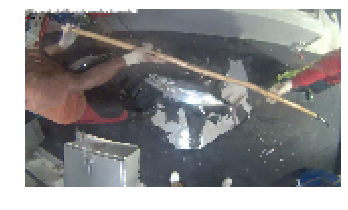

ALB         0.999872
NoF      6.92879e-05
DOL      3.31769e-05
YFT      1.76421e-05
BET      7.28171e-06
OTHER    4.34041e-07
LAG      1.55869e-07
SHARK    4.78214e-10
Name: 16, dtype: object


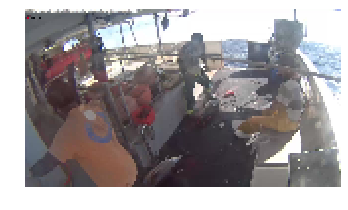

ALB         0.995462
BET        0.0025079
NoF       0.00144332
LAG      0.000326558
OTHER    0.000107246
DOL      6.26727e-05
YFT      6.08868e-05
SHARK    2.97003e-05
Name: 357, dtype: object


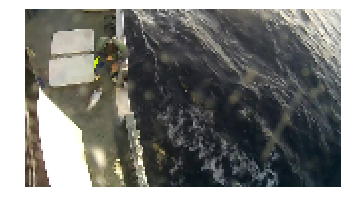

ALB         0.989391
YFT        0.0104928
NoF      0.000113105
OTHER    2.69456e-06
DOL      5.65497e-07
LAG      7.41667e-08
BET      9.62112e-09
SHARK    1.67291e-10
Name: 610, dtype: object


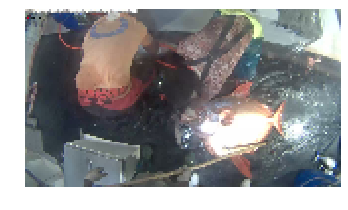

ALB         0.990604
LAG       0.00821909
NoF       0.00113721
DOL      2.92135e-05
YFT      6.05143e-06
OTHER    2.26588e-06
BET      1.95801e-06
SHARK    1.00498e-07
Name: 982, dtype: object


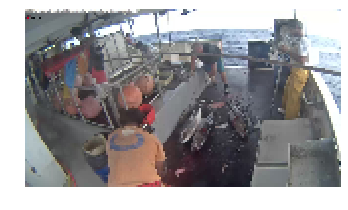

ALB           0.9995
BET      0.000490959
DOL      2.65862e-06
NoF      1.57533e-06
LAG      1.49677e-06
OTHER    1.39786e-06
YFT      1.28349e-06
SHARK    5.60491e-07
Name: 487, dtype: object


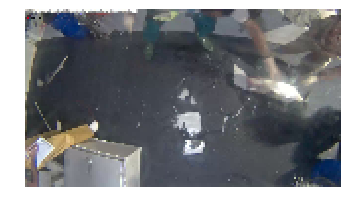

ALB         0.998315
NoF      0.000571185
YFT      0.000459766
LAG      0.000364688
BET      0.000185733
DOL      5.82217e-05
OTHER    3.69539e-05
SHARK    8.44343e-06
Name: 551, dtype: object


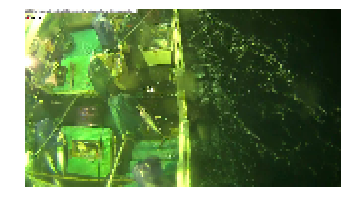

YFT         0.670157
OTHER       0.222422
ALB        0.0618433
BET        0.0382298
DOL       0.00631994
NoF      0.000924609
LAG      6.67722e-05
SHARK     3.6374e-05
Name: 77, dtype: object


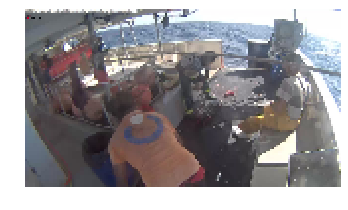

ALB         0.966447
NoF        0.0126039
DOL       0.00822469
OTHER     0.00669969
BET       0.00340917
YFT       0.00199534
LAG      0.000455988
SHARK    0.000163879
Name: 890, dtype: object


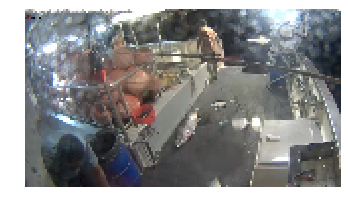

ALB         0.929098
LAG        0.0486842
OTHER     0.00943294
YFT       0.00612599
NoF       0.00581331
SHARK    0.000569033
BET      0.000200674
DOL      7.57547e-05
Name: 678, dtype: object


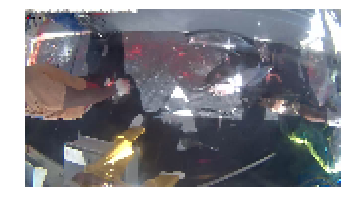

ALB         0.999917
BET       3.8203e-05
NoF      2.98991e-05
YFT      1.15775e-05
DOL      2.26641e-06
LAG       4.2442e-07
OTHER    2.75667e-07
SHARK    7.74256e-09
Name: 318, dtype: object


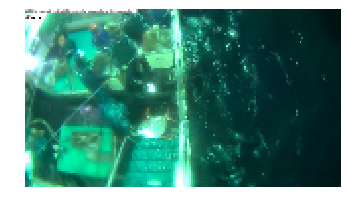

BET        0.405452
NoF        0.294636
YFT        0.198222
ALB       0.0634822
OTHER     0.0249719
SHARK    0.00725757
DOL      0.00434319
LAG      0.00163506
Name: 715, dtype: object


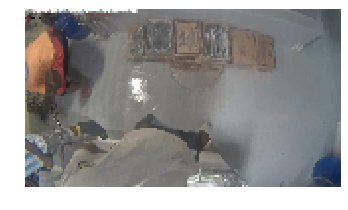

ALB         0.891938
LAG        0.0451129
YFT        0.0294839
NoF        0.0147553
BET        0.0133403
OTHER     0.00414678
DOL       0.00114223
SHARK    8.03042e-05
Name: 265, dtype: object


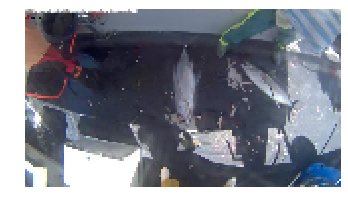

ALB         0.999475
BET      0.000463526
LAG      2.45678e-05
NoF      2.34963e-05
YFT      1.06785e-05
OTHER    2.22428e-06
SHARK    4.90937e-07
DOL      2.13962e-07
Name: 798, dtype: object


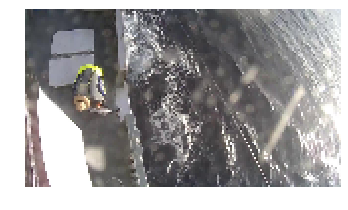

ALB         0.989004
YFT       0.00835487
NoF       0.00208054
BET      0.000454921
DOL       5.2168e-05
LAG      3.72959e-05
OTHER    1.60842e-05
SHARK    3.40925e-07
Name: 472, dtype: object


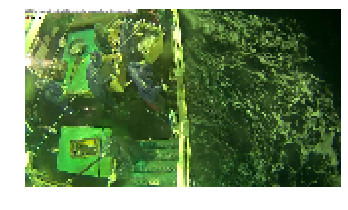

BET        0.383446
ALB        0.300382
YFT        0.181093
OTHER     0.0927359
DOL       0.0161237
NoF       0.0108571
SHARK     0.0108458
LAG      0.00451638
Name: 49, dtype: object


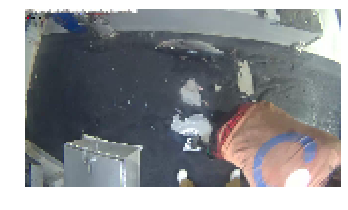

ALB         0.997516
BET      0.000810363
NoF      0.000791656
YFT      0.000626764
DOL      0.000172311
OTHER    4.47834e-05
LAG      3.81052e-05
SHARK    2.08454e-07
Name: 389, dtype: object


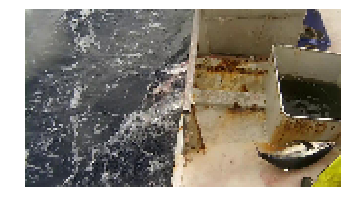

ALB         0.966107
YFT        0.0329159
NoF      0.000809017
BET      8.16327e-05
SHARK    3.49869e-05
LAG      2.57821e-05
OTHER    2.16111e-05
DOL      3.51486e-06
Name: 923, dtype: object


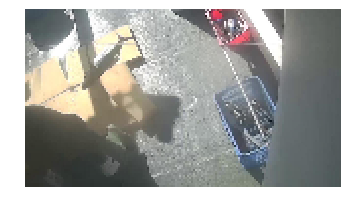

ALB         0.975981
NoF        0.0139417
YFT       0.00622013
BET       0.00246611
LAG      0.000881666
DOL      0.000241083
SHARK    0.000190881
OTHER    7.74057e-05
Name: 480, dtype: object


In [17]:
num_samples = 20
for i in range(num_samples):
    sample_prediction(np.random.randint(low=0, high=1000))

## Visualization

Using [tensorboard & tflearn](http://tflearn.org/getting_started/#visualization) to visualize the loss and accuracy functions



In [18]:
# %%bash

# tensorboard --logdir='/tmp/tflearn_logs'